In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt

import cufflinks as cf
from plotly import __version__
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot

cf.go_offline()

%matplotlib inline
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error

from neuralforecast.auto import AutoLSTM
from neuralforecast.tsdataset import TimeSeriesDataset
from neuralforecast.core import NeuralForecast
from neuralforecast.models import LSTM

from datetime import datetime, timedelta

In [2]:
import plotly.graph_objects as go
import matplotlib.colors as mcolors

In [3]:
from neuralforecast.losses.pytorch import MQLoss

In [4]:
class FixedModelLSTMProcessor:
    def __init__(self, overall_df, dates):
        self.overall_df = overall_df
        self.overall_df_value_col = "value"
        self.dates = dates
        self.dfs = []
        self.forecasts = []
        self.plotting_df = pd.DataFrame()
        
        self.maes = []
        self.mses = []
        self.mapes = []
        self.nmses = []
        
        self.metrics_df = pd.DataFrame(columns = ["Reference Date", "MAE", "MSE", "MAPE", "NMSE"])
        self.display_df = pd.DataFrame(columns = ["Reference Date", "Target End Date", "Quantile", "Prediction"])
        
        self.color_mapping = {}
    
    def create_training_dfs(self, value_col):
        self.overall_df_value_col = value_col
        for date in self.dates:
            df = self.overall_df.loc[:date]
            df['ds'] = df.index
            df["unique_id"] = "series_1"
            df = df.rename(columns = {value_col: "y"})
            self.dfs.append(df)
        
    
    def create_fixed_model(self, h, freq, model_name, level = []):
        #Creating AutoLSTM model and predicting with hyperparameter tuning by optuna backend. This is based upon the first training dataframe
        if not level:
            nf = NeuralForecast(models = [AutoLSTM(h = h, backend = "optuna")], freq = freq)
            nf.fit(df = self.dfs[0])
        else:
            nf = NeuralForecast(models = [AutoLSTM(h = h, backend = "optuna", loss = MQLoss(level = level))], freq = freq)
            nf.fit(df = self.dfs[0])
        
        for i in range(len(self.dfs)):
            df = self.dfs[i]
            y_hat = nf.predict(df = df)

            y_hat.set_index("ds", inplace = True)
            y_hat.drop(columns = "unique_id", inplace = True)
            self.forecasts.append(y_hat)

        #nf.save(path=f'./AutoLSTM/fixed_models/{model_name}/')
    
    def generate_color_map(self, columns, cmap_name = "viridis"):
        intervals = set()
        for col in columns:
            if 'median' in col:
                continue
            parts = col.split('-')
            number = parts[-1]
            intervals.add(number)
        
        intervals = sorted(intervals, key=int)
        cmap = plt.cm.get_cmap(cmap_name)
        
        n = len(intervals)
        if n > 0:
            half = np.linspace(0.2, 0.45, n // 2, endpoint=True)[::-1]  # lower intervals
            upper = np.linspace(0.55, 0.8, n - n // 2, endpoint=True)  # higher intervals
            sample_points = np.concatenate([half, upper])
        else:
            sample_points = np.array([])  # just median
        
        median_value = np.median(sample_points)
        
        color_mapping = {}
        color_mapping['median'] = mcolors.to_hex(cmap(median_value))  # center of the colormap
        for interval, point in zip(intervals, sample_points):
            color_mapping[interval] = mcolors.to_hex(cmap(point))
    
        return color_mapping
    
    def create_graph(self):
        
        #Create color map for various confidence bands, only if levels are present
        if len(self.forecasts[0].columns) != 1:
            self.color_mapping = self.generate_color_map(columns = self.forecasts[0].columns)
                
        
        for i in range(len(self.forecasts)):
            #Plot the overall Real Data
            fig = go.Figure()
            fig.add_trace(go.Scatter(x = self.overall_df.index, y = self.overall_df[self.overall_df_value_col], mode = "lines", name = "Real Data"))

            
            for col in self.forecasts[i].columns:
                #Plot his first
                if "hi" in col:
                    number = col[-2:]
                    fig.add_trace(go.Scatter(x = self.forecasts[i].index, y = self.forecasts[i][col], mode = "lines", name = col, 
                                             line = dict(color = self.color_mapping[number])))
            
            for col in self.forecasts[i].columns:
                #Lows will go to corresponding his
                if "lo" in col:
                    number = col[-2:]
                    fig.add_trace(go.Scatter(x = self.forecasts[i].index, y = self.forecasts[i][col], mode = "lines", name = col, 
                                             fill = "tonexty", fillcolor = self.color_mapping[number], line = dict(color = self.color_mapping[number])))
            
            for col in self.forecasts[i].columns:
                #Median gets plotted last
                if "median" in col:
                    fig.add_trace(go.Scatter(x = self.forecasts[i].index, y = self.forecasts[i][col], mode = "lines", name = col, 
                                             line = dict(color = self.color_mapping["median"])))
            
            #Case for if confidence interval not present
            for col in self.forecasts[i].columns:
                if col == "AutoLSTM":
                    fig.add_trace(go.Scatter(x = self.forecasts[i].index, y = self.forecasts[i]["AutoLSTM"], mode = "lines", name = "AutoLSTM"))
            
            
            fig.update_layout(title = f"Fixed Parameter LSTM Predictions, {self.dates[i]}", xaxis_title = "Date", yaxis_title = "Count", hovermode = "x")
            fig.show()
            
    def calculate_metrics(self):
        for i in range(len(self.forecasts)):
            mae = mean_absolute_error(self.overall_df[self.overall_df_value_col].loc[self.forecasts[i].index], self.forecasts[i].iloc[:, 0])
            mse = mean_squared_error(self.overall_df[self.overall_df_value_col].loc[self.forecasts[i].index], self.forecasts[i].iloc[:, 0])
            mape = mean_absolute_percentage_error(self.overall_df[self.overall_df_value_col].loc[self.forecasts[i].index], self.forecasts[i].iloc[:, 0])
            nmse = mse/np.var(self.overall_df[self.overall_df_value_col].loc[self.forecasts[i].index])
            
            self.maes.append(mae)
            self.mses.append(mse)
            self.mapes.append(mape)
            self.nmses.append(nmse)
    
    def display_maes(self):
        for i in range(len(self.maes)):
            date_obj = datetime.strptime(self.dates[i], "%Y-%m-%d")
            english_date = date_obj.strftime("%B %d, %Y")
            print(f"Mean Absolute Error for {english_date} model: {self.maes[i]}")
        
    def display_mses(self):
        for i in range(len(self.mses)):
            date_obj = datetime.strptime(self.dates[i], "%Y-%m-%d")
            english_date = date_obj.strftime("%B %d, %Y")
            print(f"Mean Squared Error for {english_date} model: {self.mses[i]}")
    
    def display_mapes(self):
        for i in range(len(self.mapes)):
            date_obj = datetime.strptime(self.dates[i], "%Y-%m-%d")
            english_date = date_obj.strftime("%B %d, %Y")
            print(f"Mean Absolute Percentage Error for {english_date} model: {self.mapes[i]}")
    
    def display_nmses(self):
        for i in range(len(self.nmses)):
            date_obj = datetime.strptime(self.dates[i], "%Y-%m-%d")
            english_date = date_obj.strftime("%B %d, %Y")
            print(f"Normalized Mean Square Error for {english_date} model: {self.nmses[i]}")
    
    def create_metrics_df(self):
        for i in range(len(self.dates)):
            self.metrics_df.loc[len(self.metrics_df)] = [self.dates[i], self.maes[i], self.mses[i], self.mapes[i], self.nmses[i]]
        
            
    def create_display_df(self):
        for i in range(len(self.forecasts)):
            for index, row in self.forecasts[i].iterrows():
                reference_date = self.dates[i]
                target_end_date = index
                
                for col in self.forecasts[i].columns:
                    value = self.forecasts[i].loc[target_end_date, col]
                    if "lo" in col:
                        number = int (col[-2:])
                        alpha = 1 - (number / 100)
                        quantile = alpha / 2
                        self.display_df.loc[len(self.display_df)] = [reference_date, target_end_date, quantile, value]

                    if col == "AutoLSTM" or "median" in col:
                        quantile = 0.5
                        self.display_df.loc[len(self.display_df)] = [reference_date, target_end_date, quantile, value]

                    elif "hi" in col:
                        number = int (col[-2:])
                        alpha = 1 - (number / 100)
                        quantile = 1 - (alpha / 2)
                        self.display_df.loc[len(self.display_df)] = [reference_date, target_end_date, quantile, value]
                
        self.display_df.sort_values(by = ["Reference Date", "Target End Date", "Quantile"], inplace = True)

In [5]:
updated_df = pd.read_csv("https://raw.githubusercontent.com/cdcepi/FluSight-forecast-hub/refs/heads/main/target-data/target-hospital-admissions.csv")

In [6]:
updated_df = updated_df[updated_df["location_name"] == "US"]
updated_df = updated_df[["date", "value"]]
updated_df["date"] = pd.to_datetime(updated_df["date"])
updated_df.set_index("date", inplace = True)
updated_df.sort_values(by = "date", inplace = True)

In [7]:
updated_df.columns[0]

'value'

In [8]:
Processor = FixedModelLSTMProcessor(overall_df = updated_df, dates = ["2024-10-05", "2024-10-19", "2024-11-02", "2024-11-16", "2024-12-07"])

In [9]:
updated_df.index

DatetimeIndex(['2022-02-05', '2022-02-12', '2022-02-19', '2022-02-26',
               '2022-03-05', '2022-03-12', '2022-03-19', '2022-03-26',
               '2022-04-02', '2022-04-09',
               ...
               '2025-02-01', '2025-02-08', '2025-02-15', '2025-02-22',
               '2025-03-01', '2025-03-08', '2025-03-15', '2025-03-22',
               '2025-03-29', '2025-04-05'],
              dtype='datetime64[ns]', name='date', length=166, freq=None)

In [10]:
len(updated_df.columns)

1

In [11]:
Processor.create_training_dfs(value_col = "value")

In [12]:
Processor.create_fixed_model(h = 4, freq = "W-SAT", model_name = "test_model", level = [80, 95])

[I 2025-04-15 17:00:23,501] A new study created in memory with name: no-name-250398a1-43ea-44ac-bc0c-e6c32bc651b2
/home/hmf6av/.local/lib/python3.11/site-packages/neuralforecast/common/_base_auto.py:291: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

[rank: 0] Seed set to 20
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
2025-04-15 17:00:27.419865: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2025-04-15 17:00:28.712232: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-04-15 17:00:28.712281: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable t

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=1000` reached.
[I 2025-04-15 17:00:54,807] Trial 0 finished with value: 145.31503295898438 and parameters: {'encoder_hidden_size': 100, 'encoder_n_layers': 4, 'context_size': 5, 'decoder_hidden_size': 64, 'learning_rate': 0.002449562548762799, 'max_steps': 1000, 'batch_size': 32, 'random_seed': 20, 'input_size': -4, 'inference_input_size': -4}. Best is trial 0 with value: 145.31503295898438.
/home/hmf6av/.local/lib/python3.11/site-packages/neuralforecast/common/_base_auto.py:291: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

[rank: 0] Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type          | Params | Mode 
--------------------------------------

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=500` reached.
[I 2025-04-15 17:00:58,865] Trial 1 finished with value: 103.72062683105469 and parameters: {'encoder_hidden_size': 100, 'encoder_n_layers': 1, 'context_size': 50, 'decoder_hidden_size': 512, 'learning_rate': 0.026460440686853458, 'max_steps': 500, 'batch_size': 16, 'random_seed': 1, 'input_size': 64, 'inference_input_size': -4}. Best is trial 1 with value: 103.72062683105469.
/home/hmf6av/.local/lib/python3.11/site-packages/neuralforecast/common/_base_auto.py:291: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

[rank: 0] Seed set to 13
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type          | Params | Mode 
--------------------------------------

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=500` reached.
[I 2025-04-15 17:01:03,023] Trial 2 finished with value: 21.334400177001953 and parameters: {'encoder_hidden_size': 50, 'encoder_n_layers': 2, 'context_size': 5, 'decoder_hidden_size': 64, 'learning_rate': 0.002691318577562917, 'max_steps': 500, 'batch_size': 16, 'random_seed': 13, 'input_size': 16, 'inference_input_size': -4}. Best is trial 2 with value: 21.334400177001953.
/home/hmf6av/.local/lib/python3.11/site-packages/neuralforecast/common/_base_auto.py:291: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

[rank: 0] Seed set to 16
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type          | Params | Mode 
----------------------------------------

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=1000` reached.
[I 2025-04-15 17:01:14,272] Trial 3 finished with value: 13.796069145202637 and parameters: {'encoder_hidden_size': 300, 'encoder_n_layers': 1, 'context_size': 50, 'decoder_hidden_size': 256, 'learning_rate': 0.015918889756025328, 'max_steps': 1000, 'batch_size': 32, 'random_seed': 16, 'input_size': -4, 'inference_input_size': -4}. Best is trial 3 with value: 13.796069145202637.
/home/hmf6av/.local/lib/python3.11/site-packages/neuralforecast/common/_base_auto.py:291: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

[rank: 0] Seed set to 2
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type          | Params | Mode 
------------------------------------

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=500` reached.
[I 2025-04-15 17:01:21,908] Trial 4 finished with value: 639.6348876953125 and parameters: {'encoder_hidden_size': 300, 'encoder_n_layers': 2, 'context_size': 5, 'decoder_hidden_size': 512, 'learning_rate': 0.057576071481634884, 'max_steps': 500, 'batch_size': 32, 'random_seed': 2, 'input_size': -4, 'inference_input_size': -4}. Best is trial 3 with value: 13.796069145202637.
/home/hmf6av/.local/lib/python3.11/site-packages/neuralforecast/common/_base_auto.py:291: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

[rank: 0] Seed set to 20
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type          | Params | Mode 
----------------------------------------

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=1000` reached.
[I 2025-04-15 17:01:37,074] Trial 5 finished with value: 13.6590576171875 and parameters: {'encoder_hidden_size': 300, 'encoder_n_layers': 2, 'context_size': 5, 'decoder_hidden_size': 64, 'learning_rate': 0.009773589067328977, 'max_steps': 1000, 'batch_size': 32, 'random_seed': 20, 'input_size': -4, 'inference_input_size': -4}. Best is trial 5 with value: 13.6590576171875.
/home/hmf6av/.local/lib/python3.11/site-packages/neuralforecast/common/_base_auto.py:291: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

[rank: 0] Seed set to 11
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type          | Params | Mode 
-----------------------------------------

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=500` reached.
[I 2025-04-15 17:01:41,457] Trial 6 finished with value: 395.17205810546875 and parameters: {'encoder_hidden_size': 50, 'encoder_n_layers': 4, 'context_size': 10, 'decoder_hidden_size': 256, 'learning_rate': 0.00012093447321985473, 'max_steps': 500, 'batch_size': 16, 'random_seed': 11, 'input_size': 256, 'inference_input_size': -4}. Best is trial 5 with value: 13.6590576171875.
/home/hmf6av/.local/lib/python3.11/site-packages/neuralforecast/common/_base_auto.py:291: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

[rank: 0] Seed set to 20
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type          | Params | Mode 
-------------------------------------

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=1000` reached.
[I 2025-04-15 17:01:51,304] Trial 7 finished with value: 749.6405639648438 and parameters: {'encoder_hidden_size': 300, 'encoder_n_layers': 3, 'context_size': 50, 'decoder_hidden_size': 64, 'learning_rate': 0.045883228383896024, 'max_steps': 1000, 'batch_size': 32, 'random_seed': 20, 'input_size': 16, 'inference_input_size': -4}. Best is trial 5 with value: 13.6590576171875.
/home/hmf6av/.local/lib/python3.11/site-packages/neuralforecast/common/_base_auto.py:291: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

[rank: 0] Seed set to 5
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type          | Params | Mode 
----------------------------------------

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=500` reached.
[I 2025-04-15 17:01:55,946] Trial 8 finished with value: 28.7402400970459 and parameters: {'encoder_hidden_size': 100, 'encoder_n_layers': 3, 'context_size': 10, 'decoder_hidden_size': 128, 'learning_rate': 0.0021134061935118996, 'max_steps': 500, 'batch_size': 32, 'random_seed': 5, 'input_size': 256, 'inference_input_size': -4}. Best is trial 5 with value: 13.6590576171875.
/home/hmf6av/.local/lib/python3.11/site-packages/neuralforecast/common/_base_auto.py:291: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

[rank: 0] Seed set to 16
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type          | Params | Mode 
----------------------------------------

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=500` reached.
[I 2025-04-15 17:02:01,775] Trial 9 finished with value: 17.45164680480957 and parameters: {'encoder_hidden_size': 200, 'encoder_n_layers': 2, 'context_size': 50, 'decoder_hidden_size': 256, 'learning_rate': 0.01316231800055163, 'max_steps': 500, 'batch_size': 32, 'random_seed': 16, 'input_size': 64, 'inference_input_size': -4}. Best is trial 5 with value: 13.6590576171875.
[rank: 0] Seed set to 20
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type          | Params | Mode 
----------------------------------------------------------
0 | loss            | MQLoss        | 5      | train
1 | padder          | ConstantPad1d | 0      | train
2 | scaler          | TemporalNorm  | 0      | train
3 | hist_encoder    | LSTM          | 1.1 M  | train
4 | context_adapter | Linear        | 6.0 K  | train
5 | mlp_decode

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=1000` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

In [31]:
len(Processor.forecasts)

5

/tmp/ipykernel_126901/219470800.py:59: MatplotlibDeprecationWarning:

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.



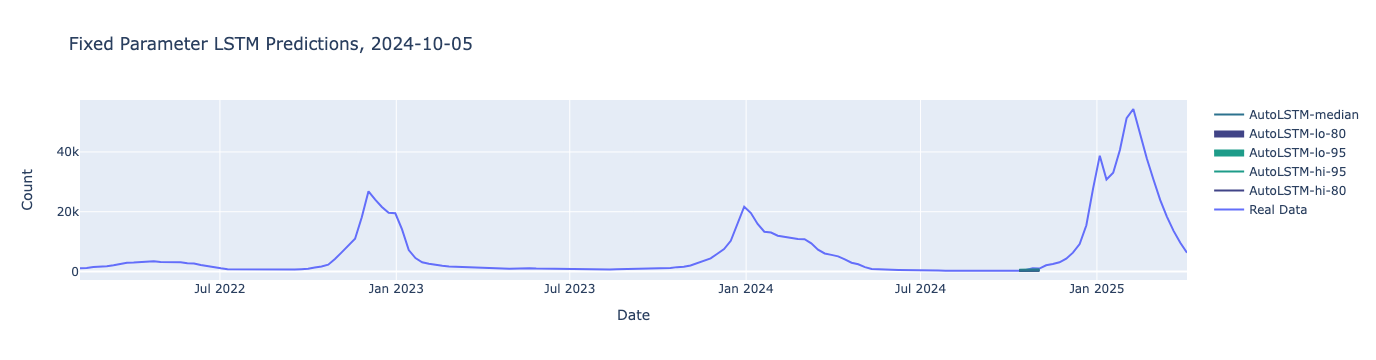

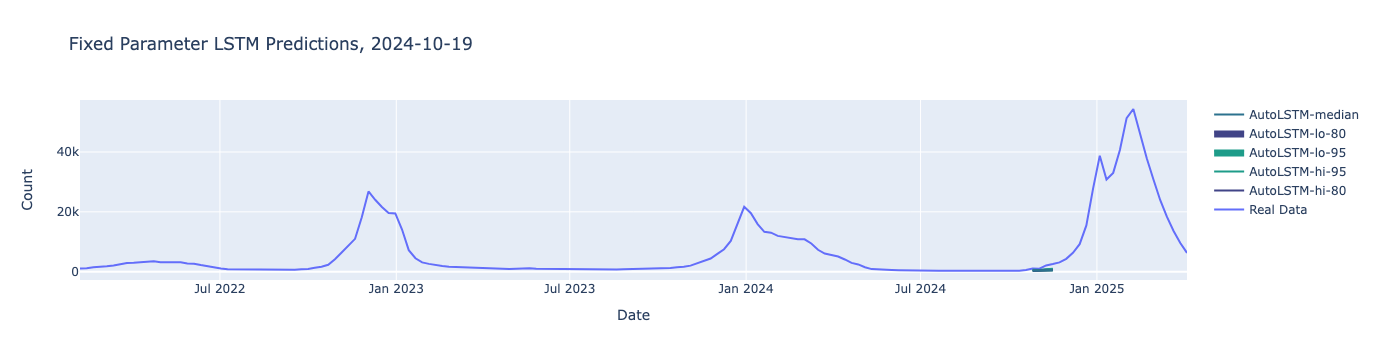

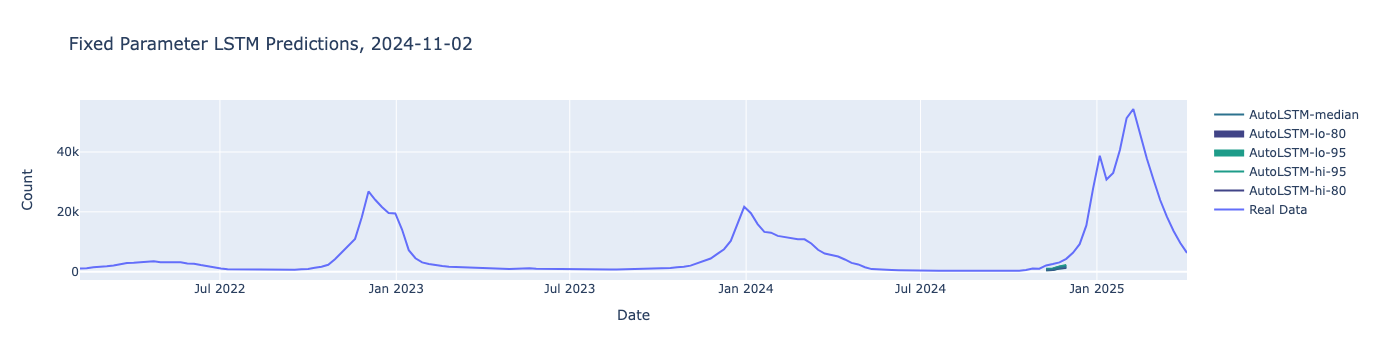

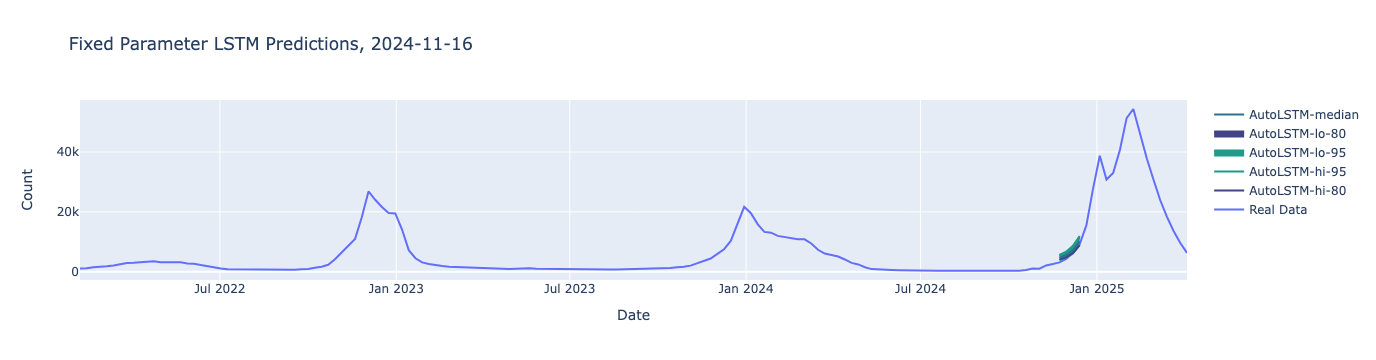

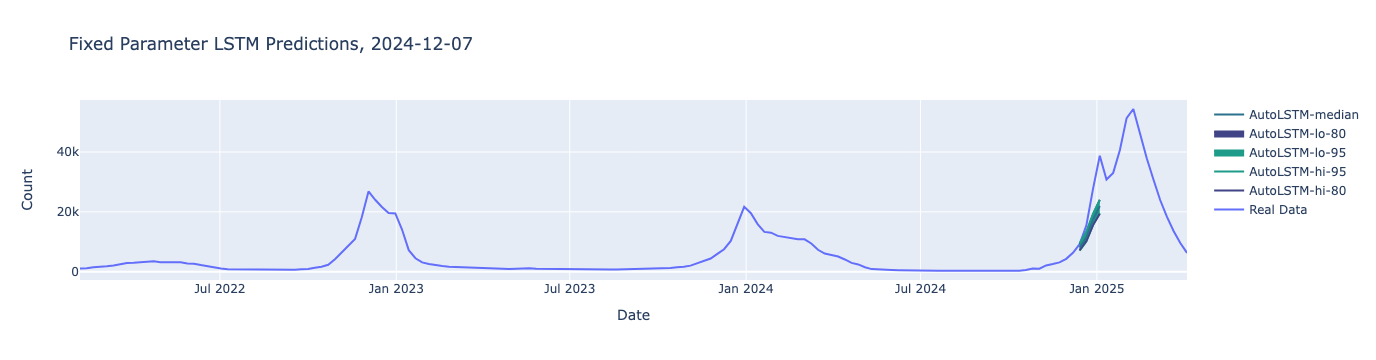

In [25]:
Processor.create_graph()

In [26]:
Processor.color_mapping

{'median': '#2c728e', '80': '#414487', '95': '#1e9c89'}

In [27]:
Processor.calculate_metrics()

In [28]:
Processor.maes

[390.3939514160156,
 1200.8799591064453,
 1922.7733612060547,
 1136.060791015625,
 8087.431640625,
 390.3939514160156,
 1200.8799591064453,
 1922.7733612060547,
 1136.060791015625,
 8087.431640625]

In [29]:
Processor.mses

[208684.5367517043,
 1770575.1309979064,
 3913024.3021358075,
 1370066.9194048643,
 102030628.80620384,
 208684.5367517043,
 1770575.1309979064,
 3913024.3021358075,
 1370066.9194048643,
 102030628.80620384]

In [30]:
Processor.mapes

[0.478339394604633,
 0.6934217911294057,
 0.6490683844551484,
 0.254860775425539,
 0.29780566378986345,
 0.478339394604633,
 0.6934217911294057,
 0.6490683844551484,
 0.254860775425539,
 0.29780566378986345]

In [20]:
Processor.create_display_df()

In [21]:
Processor.display_df

,Reference Date,Target End Date,Quantile,Prediction
1,2024-10-05,2024-10-12,0.025,198.047974
2,2024-10-05,2024-10-12,0.100,239.596558
0,2024-10-05,2024-10-12,0.500,375.685486
3,2024-10-05,2024-10-12,0.900,515.429871
4,2024-10-05,2024-10-12,0.975,560.911316
...,...,...,...,...
96,2024-12-07,2025-01-04,0.025,19554.320312
97,2024-12-07,2025-01-04,0.100,19322.017578
95,2024-12-07,2025-01-04,0.500,21950.806641
98,2024-12-07,2025-01-04,0.900,23994.619141


In [22]:
Processor.create_metrics_df()

In [23]:
Processor.metrics_df

,Reference Date,MAE,MSE,MAPE,NMSE
0,2024-10-05,390.393951,2.086845e+05,0.478339,2.051716
1,2024-10-19,1200.879959,1.770575e+06,0.693422,4.068443
2,2024-11-02,1922.773361,3.913024e+06,0.649068,5.685965
3,2024-11-16,1136.060791,1.370067e+06,0.254861,0.257364
4,2024-12-07,8087.431641,1.020306e+08,0.297806,0.787307


In [32]:
class UpdatingModelLSTMProcessor:
    def __init__(self, overall_df, dates):
        self.overall_df = overall_df
        self.overall_df_value_col = "value"
        self.dates = dates
        self.dfs = []
        self.forecasts = []
        self.plotting_df = pd.DataFrame()
        
        self.maes = []
        self.mses = []
        self.mapes = []
        self.nmses = []
        
        self.metrics_df = pd.DataFrame(columns = ["Reference Date", "MAE", "MSE", "MAPE", "NMSE"])
        self.display_df = pd.DataFrame(columns = ["Reference Date", "Target End Date", "Quantile", "Prediction"])
    
    def create_training_dfs(self, value_col):
        self.overall_df_value_col = value_col
        for date in self.dates:
            df = self.overall_df.loc[:date]
            df['ds'] = df.index
            df["unique_id"] = "series_1"
            df = df.rename(columns = {value_col: "y"})
            self.dfs.append(df)
    
    def create_models(self, h, freq, model_names, level = []):
        for i in range(len(self.dfs)):
            if not level:
                nf = NeuralForecast(models = [AutoLSTM(h = h, backend = "optuna")], freq = freq)
                nf.fit(df = self.dfs[i])
            else:
                nf = NeuralForecast(models = [AutoLSTM(h = h, backend = "optuna", loss = MQLoss(level = level))], freq = freq)
                nf.fit(df = self.dfs[i])
            
            y_hat = nf.predict(df = self.dfs[i])
            y_hat.set_index("ds", inplace = True)
            y_hat.drop(columns = "unique_id", inplace = True)
            self.forecasts.append(y_hat)

            #nf.save(path=f'./AutoLSTM/updating_models/{model_names[i]}.ckpt')
    
    def generate_color_map(self, columns, cmap_name = "viridis"):
        intervals = set()
        for col in columns:
            if 'median' in col:
                continue
            parts = col.split('-')
            number = parts[-1]
            intervals.add(number)
        
        intervals = sorted(intervals, key=int)
        cmap = plt.cm.get_cmap(cmap_name)
        
        n = len(intervals)
        if n > 0:
            half = np.linspace(0.2, 0.45, n // 2, endpoint=True)[::-1]  # lower intervals
            upper = np.linspace(0.55, 0.8, n - n // 2, endpoint=True)  # higher intervals
            sample_points = np.concatenate([half, upper])
        else:
            sample_points = np.array([])  # just median
        
        median_value = np.median(sample_points)
        
        color_mapping = {}
        color_mapping['median'] = mcolors.to_hex(cmap(median_value))  # center of the colormap
        for interval, point in zip(intervals, sample_points):
            color_mapping[interval] = mcolors.to_hex(cmap(point))
    
        return color_mapping
    
    def create_graph(self):
        
        #Create color map for various confidence bands, only if levels are present
        if len(self.forecasts[0].columns) != 1:
            self.color_mapping = self.generate_color_map(columns = self.forecasts[0].columns)
                
        
        for i in range(len(self.forecasts)):
            #Plot the overall Real Data
            fig = go.Figure()
            fig.add_trace(go.Scatter(x = self.overall_df.index, y = self.overall_df[self.overall_df_value_col], mode = "lines", name = "Real Data"))

            
            for col in self.forecasts[i].columns:
                #Plot his first
                if "hi" in col:
                    number = col[-2:]
                    fig.add_trace(go.Scatter(x = self.forecasts[i].index, y = self.forecasts[i][col], mode = "lines", name = col, 
                                             line = dict(color = self.color_mapping[number])))
            
            for col in self.forecasts[i].columns:
                #Lows will go to corresponding his
                if "lo" in col:
                    number = col[-2:]
                    fig.add_trace(go.Scatter(x = self.forecasts[i].index, y = self.forecasts[i][col], mode = "lines", name = col, 
                                             fill = "tonexty", fillcolor = self.color_mapping[number], line = dict(color = self.color_mapping[number])))
            
            for col in self.forecasts[i].columns:
                #Median gets plotted last
                if "median" in col:
                    fig.add_trace(go.Scatter(x = self.forecasts[i].index, y = self.forecasts[i][col], mode = "lines", name = col, 
                                             line = dict(color = self.color_mapping["median"])))
            
            #Case for if confidence interval not present
            for col in self.forecasts[i].columns:
                if col == "AutoLSTM":
                    fig.add_trace(go.Scatter(x = self.forecasts[i].index, y = self.forecasts[i]["AutoLSTM"], mode = "lines", name = "AutoLSTM"))
            
            
            fig.update_layout(title = f"Updating Parameter LSTM Predictions, {self.dates[i]}", xaxis_title = "Date", yaxis_title = "Count", hovermode = "x")
            fig.show()
        
        
    def calculate_metrics(self):
        for i in range(len(self.forecasts)):
            mae = mean_absolute_error(self.overall_df[self.overall_df_value_col].loc[self.forecasts[i].index], self.forecasts[i].iloc[:, 0])
            mse = mean_squared_error(self.overall_df[self.overall_df_value_col].loc[self.forecasts[i].index], self.forecasts[i].iloc[:, 0])
            mape = mean_absolute_percentage_error(self.overall_df[self.overall_df_value_col].loc[self.forecasts[i].index], self.forecasts[i].iloc[:, 0])
            nmse = mse/np.var(self.overall_df[self.overall_df_value_col].loc[self.forecasts[i].index])
            
            self.maes.append(mae)
            self.mses.append(mse)
            self.mapes.append(mape)
            self.nmses.append(nmse)
    
    def display_maes(self):
        for i in range(len(self.maes)):
            date_obj = datetime.strptime(self.dates[i], "%Y-%m-%d")
            english_date = date_obj.strftime("%B %d, %Y")
            print(f"Mean Absolute Error for {english_date} model: {self.maes[i]}")
        
    def display_mses(self):
        for i in range(len(self.mses)):
            date_obj = datetime.strptime(self.dates[i], "%Y-%m-%d")
            english_date = date_obj.strftime("%B %d, %Y")
            print(f"Mean Squared Error for {english_date} model: {self.mses[i]}")
    
    def display_mapes(self):
        for i in range(len(self.mapes)):
            date_obj = datetime.strptime(self.dates[i], "%Y-%m-%d")
            english_date = date_obj.strftime("%B %d, %Y")
            print(f"Mean Absolute Percentage Error for {english_date} model: {self.mapes[i]}")
    
    def display_nmses(self):
        for i in range(len(self.nmses)):
            date_obj = datetime.strptime(self.dates[i], "%Y-%m-%d")
            english_date = date_obj.strftime("%B %d, %Y")
            print(f"Normalized Mean Square Error for {english_date} model: {self.nmses[i]}")
        
    def create_metrics_df(self):
        for i in range(len(self.dates)):
            self.metrics_df.loc[len(self.metrics_df)] = [self.dates[i], self.maes[i], self.mses[i], self.mapes[i], self.nmses[i]]
    
    def create_display_df(self):
        for i in range(len(self.forecasts)):
            for index, row in self.forecasts[i].iterrows():
                reference_date = self.dates[i]
                target_end_date = index
                
                for col in self.forecasts[i].columns:
                    value = self.forecasts[i].loc[target_end_date, col]
                    if "lo" in col:
                        number = int (col[-2:])
                        alpha = 1 - (number / 100)
                        quantile = alpha / 2
                        self.display_df.loc[len(self.display_df)] = [reference_date, target_end_date, quantile, value]

                    if col == "AutoLSTM" or "median" in col:
                        quantile = 0.5
                        self.display_df.loc[len(self.display_df)] = [reference_date, target_end_date, quantile, value]

                    elif "hi" in col:
                        number = int (col[-2:])
                        alpha = 1 - (number / 100)
                        quantile = 1 - (alpha / 2)
                        self.display_df.loc[len(self.display_df)] = [reference_date, target_end_date, quantile, value]
                
        self.display_df.sort_values(by = ["Reference Date", "Target End Date", "Quantile"], inplace = True)
            


In [33]:
UpdatingProcessor = UpdatingModelLSTMProcessor(overall_df = updated_df, dates = ["2024-10-05", "2024-10-19", "2024-11-02", "2024-11-16", "2024-12-07"])

In [34]:
UpdatingProcessor.create_training_dfs(value_col = "value")

In [35]:
UpdatingProcessor.create_models(h = 4, freq = "W-SAT", model_names = ["test_1", "test_2", "test_3", "test_4", "test_5"], level = [80, 95])

[I 2025-04-15 17:05:51,620] A new study created in memory with name: no-name-0a575da5-57c0-4546-bc22-0b82f3ecf2d1
/home/hmf6av/.local/lib/python3.11/site-packages/neuralforecast/common/_base_auto.py:291: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

[rank: 0] Seed set to 10
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type          | Params | Mode 
----------------------------------------------------------
0 | loss            | MQLoss        | 5      | train
1 | padder          | ConstantPad1d | 0      | train
2 | scaler          | TemporalNorm  | 0      | train
3 | hist_encoder    | LSTM          | 41.2 K | train
4 | context_adapter | Linear        | 20.2 K | train
5 | mlp_decoder     | MLP   

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=500` reached.
[I 2025-04-15 17:05:55,594] Trial 0 finished with value: 18.41500473022461 and parameters: {'encoder_hidden_size': 100, 'encoder_n_layers': 1, 'context_size': 50, 'decoder_hidden_size': 256, 'learning_rate': 0.008779061096669587, 'max_steps': 500, 'batch_size': 32, 'random_seed': 10, 'input_size': 64, 'inference_input_size': -4}. Best is trial 0 with value: 18.41500473022461.
/home/hmf6av/.local/lib/python3.11/site-packages/neuralforecast/common/_base_auto.py:291: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

[rank: 0] Seed set to 16
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type          | Params | Mode 
---------------------------------------

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=1000` reached.
[I 2025-04-15 17:06:06,949] Trial 1 finished with value: 169.47476196289062 and parameters: {'encoder_hidden_size': 300, 'encoder_n_layers': 1, 'context_size': 50, 'decoder_hidden_size': 256, 'learning_rate': 0.04798887150506392, 'max_steps': 1000, 'batch_size': 16, 'random_seed': 16, 'input_size': 256, 'inference_input_size': -4}. Best is trial 0 with value: 18.41500473022461.
/home/hmf6av/.local/lib/python3.11/site-packages/neuralforecast/common/_base_auto.py:291: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

[rank: 0] Seed set to 7
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type          | Params | Mode 
-------------------------------------

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=1000` reached.
[I 2025-04-15 17:06:16,079] Trial 2 finished with value: 44.5301628112793 and parameters: {'encoder_hidden_size': 100, 'encoder_n_layers': 3, 'context_size': 10, 'decoder_hidden_size': 512, 'learning_rate': 0.0016030453375340543, 'max_steps': 1000, 'batch_size': 16, 'random_seed': 7, 'input_size': 256, 'inference_input_size': -4}. Best is trial 0 with value: 18.41500473022461.
/home/hmf6av/.local/lib/python3.11/site-packages/neuralforecast/common/_base_auto.py:291: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

[rank: 0] Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type          | Params | Mode 
--------------------------------------

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=1000` reached.
[I 2025-04-15 17:06:27,633] Trial 3 finished with value: 82.6436767578125 and parameters: {'encoder_hidden_size': 300, 'encoder_n_layers': 2, 'context_size': 50, 'decoder_hidden_size': 512, 'learning_rate': 0.00042157564206496764, 'max_steps': 1000, 'batch_size': 32, 'random_seed': 1, 'input_size': 64, 'inference_input_size': -4}. Best is trial 0 with value: 18.41500473022461.
/home/hmf6av/.local/lib/python3.11/site-packages/neuralforecast/common/_base_auto.py:291: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

[rank: 0] Seed set to 17
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type          | Params | Mode 
-------------------------------------

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=500` reached.
[I 2025-04-15 17:06:35,364] Trial 4 finished with value: 95.99085998535156 and parameters: {'encoder_hidden_size': 200, 'encoder_n_layers': 2, 'context_size': 50, 'decoder_hidden_size': 128, 'learning_rate': 0.06973603751890295, 'max_steps': 500, 'batch_size': 32, 'random_seed': 17, 'input_size': -4, 'inference_input_size': -4}. Best is trial 0 with value: 18.41500473022461.
/home/hmf6av/.local/lib/python3.11/site-packages/neuralforecast/common/_base_auto.py:291: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

[rank: 0] Seed set to 18
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type          | Params | Mode 
----------------------------------------

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=1000` reached.
[I 2025-04-15 17:06:43,766] Trial 5 finished with value: 162.9333038330078 and parameters: {'encoder_hidden_size': 50, 'encoder_n_layers': 3, 'context_size': 10, 'decoder_hidden_size': 128, 'learning_rate': 0.09424701482287692, 'max_steps': 1000, 'batch_size': 32, 'random_seed': 18, 'input_size': 16, 'inference_input_size': -4}. Best is trial 0 with value: 18.41500473022461.
/home/hmf6av/.local/lib/python3.11/site-packages/neuralforecast/common/_base_auto.py:291: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

[rank: 0] Seed set to 19
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type          | Params | Mode 
---------------------------------------

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=1000` reached.
[I 2025-04-15 17:06:58,978] Trial 6 finished with value: 6.878698825836182 and parameters: {'encoder_hidden_size': 200, 'encoder_n_layers': 2, 'context_size': 10, 'decoder_hidden_size': 128, 'learning_rate': 0.003430741901597906, 'max_steps': 1000, 'batch_size': 16, 'random_seed': 19, 'input_size': 256, 'inference_input_size': -4}. Best is trial 6 with value: 6.878698825836182.
/home/hmf6av/.local/lib/python3.11/site-packages/neuralforecast/common/_base_auto.py:291: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

[rank: 0] Seed set to 14
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type          | Params | Mode 
------------------------------------

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=500` reached.
[I 2025-04-15 17:07:03,552] Trial 7 finished with value: 75.90113830566406 and parameters: {'encoder_hidden_size': 200, 'encoder_n_layers': 2, 'context_size': 5, 'decoder_hidden_size': 256, 'learning_rate': 0.003751144637615993, 'max_steps': 500, 'batch_size': 16, 'random_seed': 14, 'input_size': 16, 'inference_input_size': -4}. Best is trial 6 with value: 6.878698825836182.
/home/hmf6av/.local/lib/python3.11/site-packages/neuralforecast/common/_base_auto.py:291: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

[rank: 0] Seed set to 4
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type          | Params | Mode 
-----------------------------------------

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=1000` reached.
[I 2025-04-15 17:07:19,017] Trial 8 finished with value: 502.2850646972656 and parameters: {'encoder_hidden_size': 300, 'encoder_n_layers': 4, 'context_size': 50, 'decoder_hidden_size': 256, 'learning_rate': 0.009309884956540735, 'max_steps': 1000, 'batch_size': 32, 'random_seed': 4, 'input_size': 64, 'inference_input_size': -4}. Best is trial 6 with value: 6.878698825836182.
/home/hmf6av/.local/lib/python3.11/site-packages/neuralforecast/common/_base_auto.py:291: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

[rank: 0] Seed set to 5
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type          | Params | Mode 
---------------------------------------

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=1000` reached.
[I 2025-04-15 17:07:27,106] Trial 9 finished with value: 38.066993713378906 and parameters: {'encoder_hidden_size': 50, 'encoder_n_layers': 2, 'context_size': 50, 'decoder_hidden_size': 512, 'learning_rate': 0.09906828104838714, 'max_steps': 1000, 'batch_size': 32, 'random_seed': 5, 'input_size': -4, 'inference_input_size': -4}. Best is trial 6 with value: 6.878698825836182.
[rank: 0] Seed set to 19
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type          | Params | Mode 
----------------------------------------------------------
0 | loss            | MQLoss        | 5      | train
1 | padder          | ConstantPad1d | 0      | train
2 | scaler          | TemporalNorm  | 0      | train
3 | hist_encoder    | LSTM          | 484 K  | train
4 | context_adapter | Linear        | 8.0 K  | train
5 | mlp_deco

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=1000` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

[I 2025-04-15 17:07:42,589] A new study created in memory with name: no-name-3f8727ed-8cbe-4558-b3a5-b21757342df9
/home/hmf6av/.local/lib/python3.11/site-packages/neuralforecast/common/_base_auto.py:291: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

[rank: 0] Seed set to 12
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type          | Params | Mode 
----------------------------------------------------------
0 | loss            | MQLoss        | 5      | train
1 | padder          | ConstantPad1d | 0      | train
2 | scaler          | TemporalNorm  | 0      | train
3 | hist_encoder    | LSTM          | 162 K  | train
4 | context_adapter | Linear        | 40.2 K | train
5 | mlp_decoder     | MLP   

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=1000` reached.
[I 2025-04-15 17:07:50,889] Trial 0 finished with value: 43.704071044921875 and parameters: {'encoder_hidden_size': 200, 'encoder_n_layers': 1, 'context_size': 50, 'decoder_hidden_size': 256, 'learning_rate': 0.0005517077892654771, 'max_steps': 1000, 'batch_size': 32, 'random_seed': 12, 'input_size': 16, 'inference_input_size': -4}. Best is trial 0 with value: 43.704071044921875.
/home/hmf6av/.local/lib/python3.11/site-packages/neuralforecast/common/_base_auto.py:291: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

[rank: 0] Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type          | Params | Mode 
-----------------------------------

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=500` reached.
[I 2025-04-15 17:08:00,592] Trial 1 finished with value: 457.0616760253906 and parameters: {'encoder_hidden_size': 300, 'encoder_n_layers': 3, 'context_size': 10, 'decoder_hidden_size': 64, 'learning_rate': 0.08151819455344778, 'max_steps': 500, 'batch_size': 32, 'random_seed': 1, 'input_size': 256, 'inference_input_size': -4}. Best is trial 0 with value: 43.704071044921875.
/home/hmf6av/.local/lib/python3.11/site-packages/neuralforecast/common/_base_auto.py:291: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

[rank: 0] Seed set to 13
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type          | Params | Mode 
----------------------------------------

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=500` reached.
[I 2025-04-15 17:08:05,149] Trial 2 finished with value: 36.666038513183594 and parameters: {'encoder_hidden_size': 100, 'encoder_n_layers': 3, 'context_size': 50, 'decoder_hidden_size': 256, 'learning_rate': 0.0026608686811290696, 'max_steps': 500, 'batch_size': 16, 'random_seed': 13, 'input_size': 256, 'inference_input_size': -4}. Best is trial 2 with value: 36.666038513183594.
/home/hmf6av/.local/lib/python3.11/site-packages/neuralforecast/common/_base_auto.py:291: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

[rank: 0] Seed set to 14
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type          | Params | Mode 
-----------------------------------

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=1000` reached.
[I 2025-04-15 17:08:14,769] Trial 3 finished with value: 44.287654876708984 and parameters: {'encoder_hidden_size': 100, 'encoder_n_layers': 4, 'context_size': 10, 'decoder_hidden_size': 256, 'learning_rate': 0.00010348576737865162, 'max_steps': 1000, 'batch_size': 16, 'random_seed': 14, 'input_size': 256, 'inference_input_size': -4}. Best is trial 2 with value: 36.666038513183594.
/home/hmf6av/.local/lib/python3.11/site-packages/neuralforecast/common/_base_auto.py:291: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

[rank: 0] Seed set to 3
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type          | Params | Mode 
---------------------------------

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=500` reached.
[I 2025-04-15 17:08:18,968] Trial 4 finished with value: 85.27750396728516 and parameters: {'encoder_hidden_size': 200, 'encoder_n_layers': 1, 'context_size': 50, 'decoder_hidden_size': 512, 'learning_rate': 0.0438537728989182, 'max_steps': 500, 'batch_size': 16, 'random_seed': 3, 'input_size': 16, 'inference_input_size': -4}. Best is trial 2 with value: 36.666038513183594.
/home/hmf6av/.local/lib/python3.11/site-packages/neuralforecast/common/_base_auto.py:291: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

[rank: 0] Seed set to 19
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type          | Params | Mode 
-----------------------------------------

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=1000` reached.
[I 2025-04-15 17:08:26,904] Trial 5 finished with value: 23.414142608642578 and parameters: {'encoder_hidden_size': 100, 'encoder_n_layers': 1, 'context_size': 50, 'decoder_hidden_size': 64, 'learning_rate': 0.003709042339102765, 'max_steps': 1000, 'batch_size': 32, 'random_seed': 19, 'input_size': 64, 'inference_input_size': -4}. Best is trial 5 with value: 23.414142608642578.
/home/hmf6av/.local/lib/python3.11/site-packages/neuralforecast/common/_base_auto.py:291: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

[rank: 0] Seed set to 7
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type          | Params | Mode 
-------------------------------------

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=500` reached.
[I 2025-04-15 17:08:31,035] Trial 6 finished with value: 41.934024810791016 and parameters: {'encoder_hidden_size': 50, 'encoder_n_layers': 2, 'context_size': 5, 'decoder_hidden_size': 128, 'learning_rate': 0.013077167738364611, 'max_steps': 500, 'batch_size': 32, 'random_seed': 7, 'input_size': 16, 'inference_input_size': -4}. Best is trial 5 with value: 23.414142608642578.
/home/hmf6av/.local/lib/python3.11/site-packages/neuralforecast/common/_base_auto.py:291: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

[rank: 0] Seed set to 2
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type          | Params | Mode 
-----------------------------------------

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=500` reached.
[I 2025-04-15 17:08:36,844] Trial 7 finished with value: 27.3023738861084 and parameters: {'encoder_hidden_size': 300, 'encoder_n_layers': 2, 'context_size': 10, 'decoder_hidden_size': 512, 'learning_rate': 0.0019334877061487812, 'max_steps': 500, 'batch_size': 32, 'random_seed': 2, 'input_size': 64, 'inference_input_size': -4}. Best is trial 5 with value: 23.414142608642578.
/home/hmf6av/.local/lib/python3.11/site-packages/neuralforecast/common/_base_auto.py:291: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

[rank: 0] Seed set to 13
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type          | Params | Mode 
---------------------------------------

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=500` reached.
[I 2025-04-15 17:08:48,552] Trial 8 finished with value: 39.533119201660156 and parameters: {'encoder_hidden_size': 300, 'encoder_n_layers': 4, 'context_size': 50, 'decoder_hidden_size': 128, 'learning_rate': 0.0020191559386947815, 'max_steps': 500, 'batch_size': 16, 'random_seed': 13, 'input_size': 256, 'inference_input_size': -4}. Best is trial 5 with value: 23.414142608642578.
/home/hmf6av/.local/lib/python3.11/site-packages/neuralforecast/common/_base_auto.py:291: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

[rank: 0] Seed set to 5
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type          | Params | Mode 
------------------------------------

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=1000` reached.
[I 2025-04-15 17:08:57,296] Trial 9 finished with value: 69.58572387695312 and parameters: {'encoder_hidden_size': 100, 'encoder_n_layers': 4, 'context_size': 5, 'decoder_hidden_size': 512, 'learning_rate': 0.0001545043832284985, 'max_steps': 1000, 'batch_size': 16, 'random_seed': 5, 'input_size': 16, 'inference_input_size': -4}. Best is trial 5 with value: 23.414142608642578.
[rank: 0] Seed set to 19
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type          | Params | Mode 
----------------------------------------------------------
0 | loss            | MQLoss        | 5      | train
1 | padder          | ConstantPad1d | 0      | train
2 | scaler          | TemporalNorm  | 0      | train
3 | hist_encoder    | LSTM          | 41.2 K | train
4 | context_adapter | Linear        | 20.2 K | train
5 | mlp_de

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=1000` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

[I 2025-04-15 17:09:05,167] A new study created in memory with name: no-name-95f8435d-dcd6-4caa-8d2d-861ba6633d72
/home/hmf6av/.local/lib/python3.11/site-packages/neuralforecast/common/_base_auto.py:291: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

[rank: 0] Seed set to 12
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type          | Params | Mode 
----------------------------------------------------------
0 | loss            | MQLoss        | 5      | train
1 | padder          | ConstantPad1d | 0      | train
2 | scaler          | TemporalNorm  | 0      | train
3 | hist_encoder    | LSTM          | 122 K  | train
4 | context_adapter | Linear        | 20.2 K | train
5 | mlp_decoder     | MLP   

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=500` reached.
[I 2025-04-15 17:09:09,298] Trial 0 finished with value: 170.65463256835938 and parameters: {'encoder_hidden_size': 100, 'encoder_n_layers': 2, 'context_size': 50, 'decoder_hidden_size': 64, 'learning_rate': 0.0019789331344996245, 'max_steps': 500, 'batch_size': 32, 'random_seed': 12, 'input_size': 64, 'inference_input_size': -4}. Best is trial 0 with value: 170.65463256835938.
/home/hmf6av/.local/lib/python3.11/site-packages/neuralforecast/common/_base_auto.py:291: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

[rank: 0] Seed set to 5
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type          | Params | Mode 
--------------------------------------

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=500` reached.
[I 2025-04-15 17:09:13,419] Trial 1 finished with value: 118.246337890625 and parameters: {'encoder_hidden_size': 50, 'encoder_n_layers': 2, 'context_size': 5, 'decoder_hidden_size': 64, 'learning_rate': 0.0017346795220831478, 'max_steps': 500, 'batch_size': 32, 'random_seed': 5, 'input_size': 64, 'inference_input_size': -4}. Best is trial 1 with value: 118.246337890625.
/home/hmf6av/.local/lib/python3.11/site-packages/neuralforecast/common/_base_auto.py:291: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

[rank: 0] Seed set to 16
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type          | Params | Mode 
--------------------------------------------

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type          | Params | Mode 
----------------------------------------------------------
0 | loss            | MQLoss        | 5      | train
1 | padder          | ConstantPad1d | 0      | train
2 | scaler          | TemporalNorm  | 0      | train
3 | hist_encoder    | LSTM          | 805 K  | train
4 | context_adapter | Linear        | 8.0 K  | train
5 | mlp_decoder     | MLP           | 1.0 K  | train
----------------------------------------------------------
814 K     Trainable params
5         Non-trainable params
814 K     Total params
3.259     Total estimated model params size (MB)
11        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=500` reached.
[I 2025-04-15 17:09:32,855] Trial 4 finished with value: 81.90483093261719 and parameters: {'encoder_hidden_size': 200, 'encoder_n_layers': 3, 'context_size': 10, 'decoder_hidden_size': 64, 'learning_rate': 0.001050526619832331, 'max_steps': 500, 'batch_size': 32, 'random_seed': 17, 'input_size': 64, 'inference_input_size': -4}. Best is trial 4 with value: 81.90483093261719.
/home/hmf6av/.local/lib/python3.11/site-packages/neuralforecast/common/_base_auto.py:291: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

[rank: 0] Seed set to 2
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type          | Params | Mode 
-----------------------------------------

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=1000` reached.
[I 2025-04-15 17:09:42,359] Trial 5 finished with value: 142.40415954589844 and parameters: {'encoder_hidden_size': 300, 'encoder_n_layers': 1, 'context_size': 10, 'decoder_hidden_size': 512, 'learning_rate': 0.0037453562779351177, 'max_steps': 1000, 'batch_size': 32, 'random_seed': 2, 'input_size': 64, 'inference_input_size': -4}. Best is trial 4 with value: 81.90483093261719.
/home/hmf6av/.local/lib/python3.11/site-packages/neuralforecast/common/_base_auto.py:291: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

[rank: 0] Seed set to 9
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type          | Params | Mode 
-------------------------------------

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=500` reached.
[I 2025-04-15 17:09:46,604] Trial 6 finished with value: 77.96370697021484 and parameters: {'encoder_hidden_size': 50, 'encoder_n_layers': 3, 'context_size': 50, 'decoder_hidden_size': 64, 'learning_rate': 0.00017331364123031844, 'max_steps': 500, 'batch_size': 32, 'random_seed': 9, 'input_size': 256, 'inference_input_size': -4}. Best is trial 6 with value: 77.96370697021484.
/home/hmf6av/.local/lib/python3.11/site-packages/neuralforecast/common/_base_auto.py:291: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

[rank: 0] Seed set to 14
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type          | Params | Mode 
---------------------------------------

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=1000` reached.
[I 2025-04-15 17:09:58,155] Trial 7 finished with value: 192.1230010986328 and parameters: {'encoder_hidden_size': 300, 'encoder_n_layers': 2, 'context_size': 5, 'decoder_hidden_size': 256, 'learning_rate': 0.0020805012938081074, 'max_steps': 1000, 'batch_size': 32, 'random_seed': 14, 'input_size': 64, 'inference_input_size': -4}. Best is trial 6 with value: 77.96370697021484.
/home/hmf6av/.local/lib/python3.11/site-packages/neuralforecast/common/_base_auto.py:291: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

[rank: 0] Seed set to 9
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type          | Params | Mode 
--------------------------------------

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=1000` reached.
[I 2025-04-15 17:10:17,942] Trial 9 finished with value: 371.2605895996094 and parameters: {'encoder_hidden_size': 300, 'encoder_n_layers': 3, 'context_size': 5, 'decoder_hidden_size': 64, 'learning_rate': 0.08792742083637604, 'max_steps': 1000, 'batch_size': 16, 'random_seed': 17, 'input_size': 16, 'inference_input_size': -4}. Best is trial 6 with value: 77.96370697021484.
[rank: 0] Seed set to 9
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type          | Params | Mode 
----------------------------------------------------------
0 | loss            | MQLoss        | 5      | train
1 | padder          | ConstantPad1d | 0      | train
2 | scaler          | TemporalNorm  | 0      | train
3 | hist_encoder    | LSTM          | 51.4 K | train
4 | context_adapter | Linear        | 10.2 K | train
5 | mlp_decode

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=500` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

[I 2025-04-15 17:10:22,181] A new study created in memory with name: no-name-704d94fa-eea3-4e88-8337-43dfd4de4628
/home/hmf6av/.local/lib/python3.11/site-packages/neuralforecast/common/_base_auto.py:291: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

[rank: 0] Seed set to 10
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type          | Params | Mode 
----------------------------------------------------------
0 | loss            | MQLoss        | 5      | train
1 | padder          | ConstantPad1d | 0      | train
2 | scaler          | TemporalNorm  | 0      | train
3 | hist_encoder    | LSTM          | 363 K  | train
4 | context_adapter | Linear        | 6.0 K  | train
5 | mlp_decoder     | MLP   

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=500` reached.
[I 2025-04-15 17:10:27,954] Trial 0 finished with value: 481.90771484375 and parameters: {'encoder_hidden_size': 300, 'encoder_n_layers': 1, 'context_size': 5, 'decoder_hidden_size': 128, 'learning_rate': 0.03633923910257625, 'max_steps': 500, 'batch_size': 16, 'random_seed': 10, 'input_size': 256, 'inference_input_size': -4}. Best is trial 0 with value: 481.90771484375.
/home/hmf6av/.local/lib/python3.11/site-packages/neuralforecast/common/_base_auto.py:291: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

[rank: 0] Seed set to 12
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type          | Params | Mode 
--------------------------------------------

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=1000` reached.
[I 2025-04-15 17:10:43,485] Trial 1 finished with value: 459.0541076660156 and parameters: {'encoder_hidden_size': 300, 'encoder_n_layers': 4, 'context_size': 10, 'decoder_hidden_size': 64, 'learning_rate': 0.015075950113197649, 'max_steps': 1000, 'batch_size': 32, 'random_seed': 12, 'input_size': 64, 'inference_input_size': -4}. Best is trial 1 with value: 459.0541076660156.
/home/hmf6av/.local/lib/python3.11/site-packages/neuralforecast/common/_base_auto.py:291: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

[rank: 0] Seed set to 20
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type          | Params | Mode 
--------------------------------------

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=500` reached.
[I 2025-04-15 17:10:48,227] Trial 2 finished with value: 184.69033813476562 and parameters: {'encoder_hidden_size': 200, 'encoder_n_layers': 1, 'context_size': 10, 'decoder_hidden_size': 128, 'learning_rate': 0.002095924294003974, 'max_steps': 500, 'batch_size': 16, 'random_seed': 20, 'input_size': 64, 'inference_input_size': -4}. Best is trial 2 with value: 184.69033813476562.
/home/hmf6av/.local/lib/python3.11/site-packages/neuralforecast/common/_base_auto.py:291: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

[rank: 0] Seed set to 3
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type          | Params | Mode 
--------------------------------------

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=500` reached.
[I 2025-04-15 17:10:52,187] Trial 3 finished with value: 288.9997863769531 and parameters: {'encoder_hidden_size': 50, 'encoder_n_layers': 1, 'context_size': 50, 'decoder_hidden_size': 256, 'learning_rate': 0.07992396487412062, 'max_steps': 500, 'batch_size': 32, 'random_seed': 3, 'input_size': 64, 'inference_input_size': -4}. Best is trial 2 with value: 184.69033813476562.
/home/hmf6av/.local/lib/python3.11/site-packages/neuralforecast/common/_base_auto.py:291: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

[rank: 0] Seed set to 11
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type          | Params | Mode 
-----------------------------------------

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=1000` reached.
[I 2025-04-15 17:11:15,801] Trial 4 finished with value: 199.77508544921875 and parameters: {'encoder_hidden_size': 200, 'encoder_n_layers': 4, 'context_size': 5, 'decoder_hidden_size': 256, 'learning_rate': 0.008301284736948255, 'max_steps': 1000, 'batch_size': 32, 'random_seed': 11, 'input_size': 256, 'inference_input_size': -4}. Best is trial 2 with value: 184.69033813476562.
/home/hmf6av/.local/lib/python3.11/site-packages/neuralforecast/common/_base_auto.py:291: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

[rank: 0] Seed set to 20
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type          | Params | Mode 
-----------------------------------

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=1000` reached.
[I 2025-04-15 17:11:23,576] Trial 5 finished with value: 218.5906219482422 and parameters: {'encoder_hidden_size': 50, 'encoder_n_layers': 1, 'context_size': 5, 'decoder_hidden_size': 128, 'learning_rate': 0.0012859925077875467, 'max_steps': 1000, 'batch_size': 16, 'random_seed': 20, 'input_size': 16, 'inference_input_size': -4}. Best is trial 2 with value: 184.69033813476562.
/home/hmf6av/.local/lib/python3.11/site-packages/neuralforecast/common/_base_auto.py:291: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

[rank: 0] Seed set to 6
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type          | Params | Mode 
--------------------------------------

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=1000` reached.
[I 2025-04-15 17:11:31,315] Trial 6 finished with value: 282.98016357421875 and parameters: {'encoder_hidden_size': 50, 'encoder_n_layers': 1, 'context_size': 10, 'decoder_hidden_size': 512, 'learning_rate': 0.001508853707194494, 'max_steps': 1000, 'batch_size': 16, 'random_seed': 6, 'input_size': -4, 'inference_input_size': -4}. Best is trial 2 with value: 184.69033813476562.
/home/hmf6av/.local/lib/python3.11/site-packages/neuralforecast/common/_base_auto.py:291: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

[rank: 0] Seed set to 3
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type          | Params | Mode 
--------------------------------------

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=1000` reached.
[I 2025-04-15 17:11:41,833] Trial 7 finished with value: 465.64471435546875 and parameters: {'encoder_hidden_size': 200, 'encoder_n_layers': 4, 'context_size': 5, 'decoder_hidden_size': 512, 'learning_rate': 0.06184797803185605, 'max_steps': 1000, 'batch_size': 16, 'random_seed': 3, 'input_size': 16, 'inference_input_size': -4}. Best is trial 2 with value: 184.69033813476562.
/home/hmf6av/.local/lib/python3.11/site-packages/neuralforecast/common/_base_auto.py:291: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

[rank: 0] Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type          | Params | Mode 
---------------------------------------

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=1000` reached.
[I 2025-04-15 17:11:58,492] Trial 9 finished with value: 154.729736328125 and parameters: {'encoder_hidden_size': 100, 'encoder_n_layers': 3, 'context_size': 50, 'decoder_hidden_size': 512, 'learning_rate': 0.00031863745579635506, 'max_steps': 1000, 'batch_size': 32, 'random_seed': 15, 'input_size': 16, 'inference_input_size': -4}. Best is trial 9 with value: 154.729736328125.
[rank: 0] Seed set to 15
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type          | Params | Mode 
----------------------------------------------------------
0 | loss            | MQLoss        | 5      | train
1 | padder          | ConstantPad1d | 0      | train
2 | scaler          | TemporalNorm  | 0      | train
3 | hist_encoder    | LSTM          | 202 K  | train
4 | context_adapter | Linear        | 20.2 K | train
5 | mlp_de

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=1000` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

[I 2025-04-15 17:12:06,946] A new study created in memory with name: no-name-573bb2cb-f4a0-4fd0-9c4d-c7e1e5c63f8e
/home/hmf6av/.local/lib/python3.11/site-packages/neuralforecast/common/_base_auto.py:291: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

[rank: 0] Seed set to 6
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type          | Params | Mode 
----------------------------------------------------------
0 | loss            | MQLoss        | 5      | train
1 | padder          | ConstantPad1d | 0      | train
2 | scaler          | TemporalNorm  | 0      | train
3 | hist_encoder    | LSTM          | 41.2 K | train
4 | context_adapter | Linear        | 20.2 K | train
5 | mlp_decoder     | MLP    

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=1000` reached.
[I 2025-04-15 17:12:22,953] Trial 1 finished with value: 461.7686462402344 and parameters: {'encoder_hidden_size': 50, 'encoder_n_layers': 2, 'context_size': 10, 'decoder_hidden_size': 256, 'learning_rate': 0.012271669413591877, 'max_steps': 1000, 'batch_size': 32, 'random_seed': 17, 'input_size': 64, 'inference_input_size': -4}. Best is trial 1 with value: 461.7686462402344.
/home/hmf6av/.local/lib/python3.11/site-packages/neuralforecast/common/_base_auto.py:291: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

[rank: 0] Seed set to 7
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type          | Params | Mode 
---------------------------------------

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=500` reached.
[I 2025-04-15 17:12:27,361] Trial 2 finished with value: 407.7505187988281 and parameters: {'encoder_hidden_size': 50, 'encoder_n_layers': 4, 'context_size': 10, 'decoder_hidden_size': 64, 'learning_rate': 0.0008049932688983207, 'max_steps': 500, 'batch_size': 16, 'random_seed': 7, 'input_size': 16, 'inference_input_size': -4}. Best is trial 2 with value: 407.7505187988281.
/home/hmf6av/.local/lib/python3.11/site-packages/neuralforecast/common/_base_auto.py:291: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

[rank: 0] Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type          | Params | Mode 
------------------------------------------

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=1000` reached.
[I 2025-04-15 17:12:35,199] Trial 3 finished with value: 404.25323486328125 and parameters: {'encoder_hidden_size': 100, 'encoder_n_layers': 1, 'context_size': 5, 'decoder_hidden_size': 64, 'learning_rate': 0.00015491037265690037, 'max_steps': 1000, 'batch_size': 16, 'random_seed': 1, 'input_size': -4, 'inference_input_size': -4}. Best is trial 3 with value: 404.25323486328125.
/home/hmf6av/.local/lib/python3.11/site-packages/neuralforecast/common/_base_auto.py:291: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

[rank: 0] Seed set to 4
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type          | Params | Mode 
-------------------------------------

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=1000` reached.
[I 2025-04-15 17:12:48,838] Trial 4 finished with value: 823.7269287109375 and parameters: {'encoder_hidden_size': 300, 'encoder_n_layers': 3, 'context_size': 50, 'decoder_hidden_size': 512, 'learning_rate': 0.0006310434606723826, 'max_steps': 1000, 'batch_size': 16, 'random_seed': 4, 'input_size': 64, 'inference_input_size': -4}. Best is trial 3 with value: 404.25323486328125.
/home/hmf6av/.local/lib/python3.11/site-packages/neuralforecast/common/_base_auto.py:291: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

[rank: 0] Seed set to 8
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type          | Params | Mode 
-------------------------------------

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=1000` reached.
[I 2025-04-15 17:12:58,058] Trial 5 finished with value: 717.4933471679688 and parameters: {'encoder_hidden_size': 100, 'encoder_n_layers': 3, 'context_size': 50, 'decoder_hidden_size': 64, 'learning_rate': 0.007445771200011166, 'max_steps': 1000, 'batch_size': 32, 'random_seed': 8, 'input_size': -4, 'inference_input_size': -4}. Best is trial 3 with value: 404.25323486328125.
/home/hmf6av/.local/lib/python3.11/site-packages/neuralforecast/common/_base_auto.py:291: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

[rank: 0] Seed set to 8
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type          | Params | Mode 
---------------------------------------

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=1000` reached.
[I 2025-04-15 17:13:07,249] Trial 6 finished with value: 560.5953369140625 and parameters: {'encoder_hidden_size': 100, 'encoder_n_layers': 3, 'context_size': 10, 'decoder_hidden_size': 64, 'learning_rate': 0.0001838005595959811, 'max_steps': 1000, 'batch_size': 16, 'random_seed': 8, 'input_size': 256, 'inference_input_size': -4}. Best is trial 3 with value: 404.25323486328125.
/home/hmf6av/.local/lib/python3.11/site-packages/neuralforecast/common/_base_auto.py:291: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

[rank: 0] Seed set to 4
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type          | Params | Mode 
-------------------------------------

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=1000` reached.
[I 2025-04-15 17:13:17,001] Trial 7 finished with value: 434.517578125 and parameters: {'encoder_hidden_size': 100, 'encoder_n_layers': 4, 'context_size': 10, 'decoder_hidden_size': 128, 'learning_rate': 0.01474174009349921, 'max_steps': 1000, 'batch_size': 16, 'random_seed': 4, 'input_size': -4, 'inference_input_size': -4}. Best is trial 3 with value: 404.25323486328125.
/home/hmf6av/.local/lib/python3.11/site-packages/neuralforecast/common/_base_auto.py:291: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

[rank: 0] Seed set to 13
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type          | Params | Mode 
------------------------------------------

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=500` reached.
[I 2025-04-15 17:13:37,469] Trial 9 finished with value: 168.7127685546875 and parameters: {'encoder_hidden_size': 300, 'encoder_n_layers': 4, 'context_size': 10, 'decoder_hidden_size': 64, 'learning_rate': 0.011436409034072737, 'max_steps': 500, 'batch_size': 16, 'random_seed': 16, 'input_size': 256, 'inference_input_size': -4}. Best is trial 9 with value: 168.7127685546875.
[rank: 0] Seed set to 16
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type          | Params | Mode 
----------------------------------------------------------
0 | loss            | MQLoss        | 5      | train
1 | padder          | ConstantPad1d | 0      | train
2 | scaler          | TemporalNorm  | 0      | train
3 | hist_encoder    | LSTM          | 2.5 M  | train
4 | context_adapter | Linear        | 12.0 K | train
5 | mlp_deco

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=500` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

In [36]:
UpdatingProcessor.forecasts[2]

,AutoLSTM-median,AutoLSTM-lo-95,AutoLSTM-lo-80,AutoLSTM-hi-80,AutoLSTM-hi-95
ds,,,,,
2024-11-09,610.284180,270.053711,346.843079,751.599182,1229.618530
2024-11-16,681.542969,319.745850,309.726624,862.325684,1405.022583
2024-11-23,722.636658,177.352295,302.751892,1154.597290,1775.379883
2024-11-30,927.005249,93.984253,253.352783,1535.744141,2157.100586


/tmp/ipykernel_126901/619611166.py:53: MatplotlibDeprecationWarning:

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.



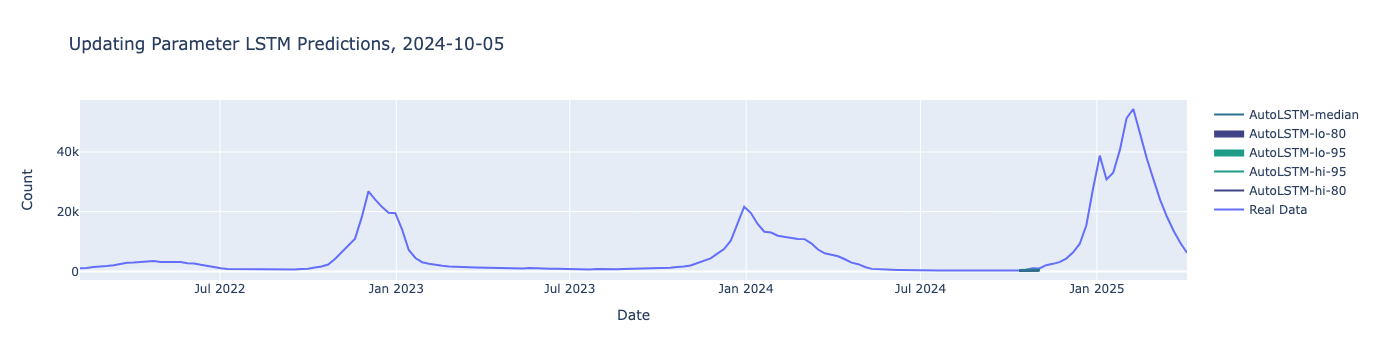

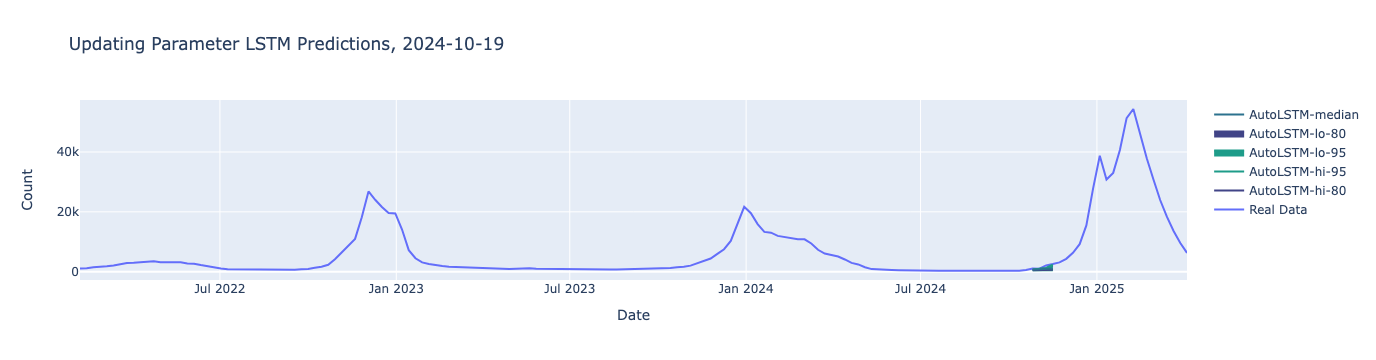

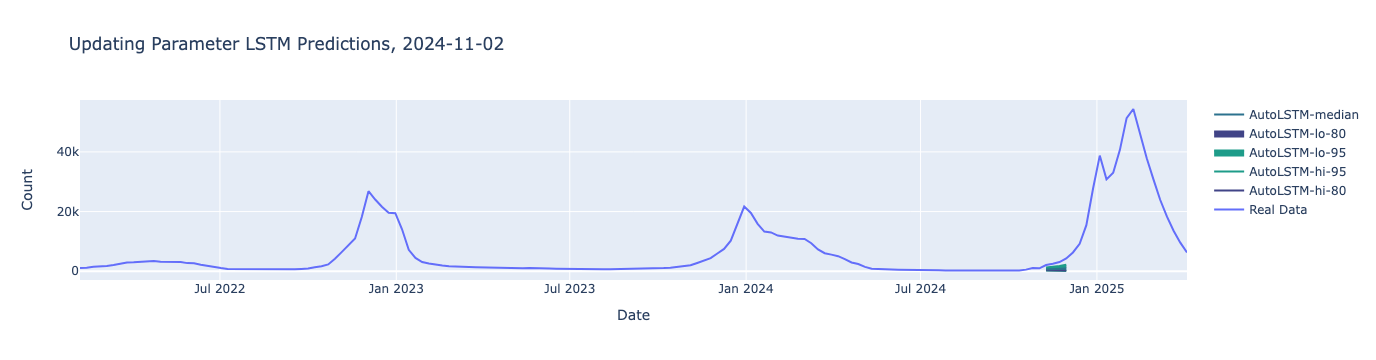

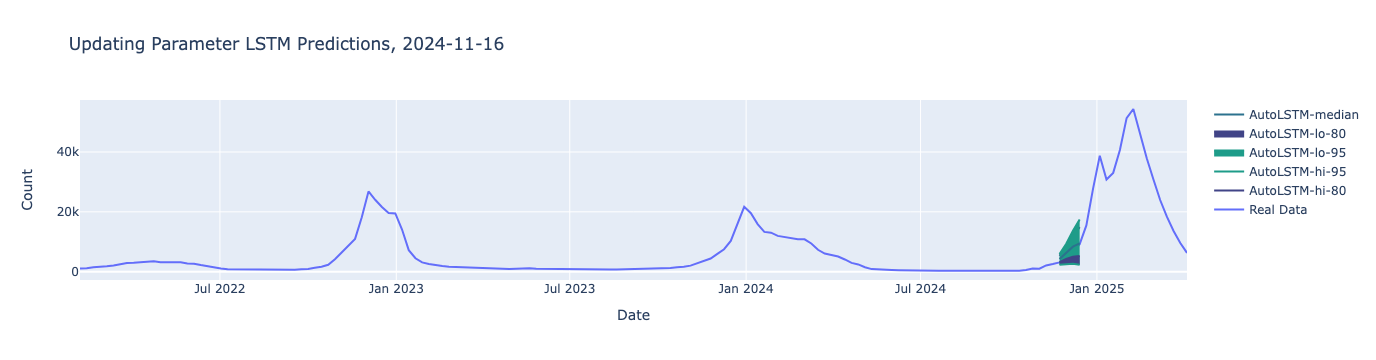

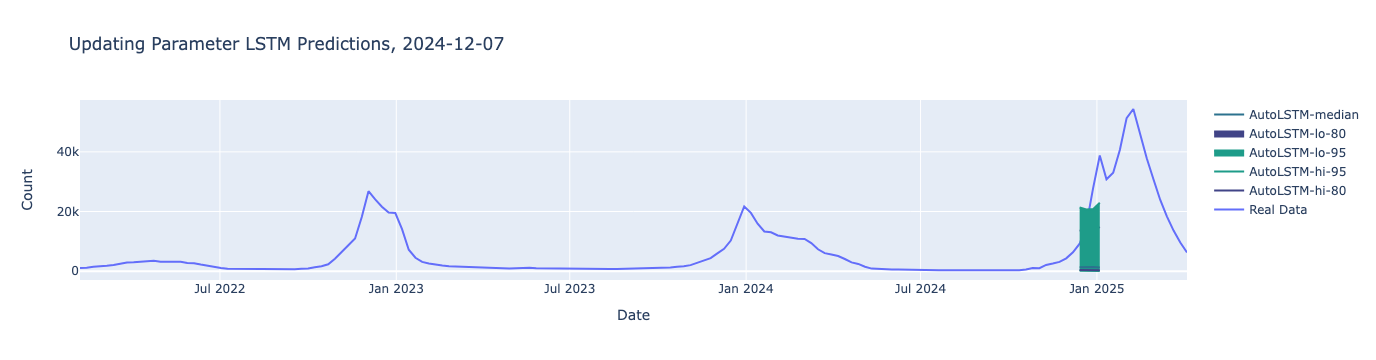

In [37]:
UpdatingProcessor.create_graph()

In [38]:
UpdatingProcessor.calculate_metrics()

In [39]:
UpdatingProcessor.maes

[387.15699768066406,
 859.7452545166016,
 2267.6327362060547,
 1338.37060546875,
 21471.47821044922]

In [40]:
UpdatingProcessor.create_display_df()

In [41]:
UpdatingProcessor.display_df

,Reference Date,Target End Date,Quantile,Prediction
1,2024-10-05,2024-10-12,0.025,141.797607
2,2024-10-05,2024-10-12,0.100,239.532959
0,2024-10-05,2024-10-12,0.500,288.479614
3,2024-10-05,2024-10-12,0.900,337.762085
4,2024-10-05,2024-10-12,0.975,512.156738
...,...,...,...,...
96,2024-12-07,2025-01-04,0.025,48.683228
97,2024-12-07,2025-01-04,0.100,340.569946
95,2024-12-07,2025-01-04,0.500,1210.011841
98,2024-12-07,2025-01-04,0.900,14809.639648


In [42]:
UpdatingProcessor.create_metrics_df()

In [43]:
UpdatingProcessor.metrics_df

,Reference Date,MAE,MSE,MAPE,NMSE
0,2024-10-05,387.156998,2.313118e+05,0.426971,2.274180
1,2024-10-19,859.745255,9.740625e+05,0.475052,2.238209
2,2024-11-02,2267.632736,5.650569e+06,0.747241,8.210769
3,2024-11-16,1338.370605,2.313306e+06,0.291330,0.434549
4,2024-12-07,21471.478210,5.912120e+08,0.922156,4.562013


In [44]:
Processor.metrics_df

,Reference Date,MAE,MSE,MAPE,NMSE
0,2024-10-05,390.393951,2.086845e+05,0.478339,2.051716
1,2024-10-19,1200.879959,1.770575e+06,0.693422,4.068443
2,2024-11-02,1922.773361,3.913024e+06,0.649068,5.685965
3,2024-11-16,1136.060791,1.370067e+06,0.254861,0.257364
4,2024-12-07,8087.431641,1.020306e+08,0.297806,0.787307


In [45]:
LSTMmodel = AutoLSTM(h = 4, backend = "optuna")

In [46]:
LSTMmodel.load(path=f'./AutoLSTM/updating_models/test_model.ckpt')

AttributeError: 'AutoLSTM' object has no attribute 'load'

In [ ]:
nf = NeuralForecast(models = [LSTM(h = 4)], freq = "W-SAT")

In [ ]:
nf.load(path=f'./AutoLSTM/fixed_models/test_model')

In [ ]:
AutoLSTM.save?

In [ ]:
!pwd

In [ ]:
!ls